In [2]:
!pip install indic-transliteration
!pip install langdetect
!pip install deep_translator
!pip install transformers
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.3/143.3 kB 12.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 39.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993243 sha256=4e5a2eaf242852f48d5ae95d3a72e08d9916e5d29370d1ba52e3a2a2f51e3cc6
  Stored in directory: /root/.cache/pip/wheels/d1/c1/d9/7e068de779d863bc8f8fc9467d85e25cfe47fa5051fff1a1bb
Successfully built langdetect
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached transformers-4.28.1-py3-none-any.whl (7.0 MB)
  Using cached huggingface_hub-0.14.1-py3-no

In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils  import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from indic_transliteration import sanscript
from langdetect import detect
from deep_translator import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
import re
import nltk
import unicodedata
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import transformers
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup



In [20]:
import torch
from torch.utils.data import TensorDataset, random_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

In [4]:
data = pd.read_csv('df.csv',delimiter=',')
data.insert(2,'converted',' ')
data.insert(3,'preprocessed',' ')


In [5]:
#Preprocessing-1
def remove_special_chars(text):
  special_chars = ['!','\"','#','$','%','&',"\'",'(', ')','*','+','-','.','...','/',':',';','<','=','>','?']
  current  = text.split()
  for i in current:
    if i in special_chars:
      current.remove(i)
  return " ".join(current)

In [6]:
for i in range(len(data['JOKES'])):
  data['preprocessed'][i] = remove_special_chars(data['JOKES'][i])

<ipython-input-6-506c0aab2dba>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['preprocessed'][i] = remove_special_chars(data['JOKES'][i])


In [7]:
# Detecting language kannada or english
def check_language(word):
    if all(unicodedata.category(c).startswith('L') for c in word):
        if any(0x0C80 <= ord(c) <= 0x0CFF for c in word):
            return 'Kannada'
        else:
            return 'English'
    else:
        return 'Not a word'



In [8]:
# Preprocessing-2
def to_kannada(text):
  res = []
  for i in text.split(" "):
    if check_language(i) == "English":
      result = GoogleTranslator(source='auto', target='kn').translate(i)
      res.append(result)
    else:
      res.append(i)
  return " ".join(res)

In [9]:
for i in range(len(data['preprocessed'])):
  
  data['converted'][i] = to_kannada(data['preprocessed'][i])

<ipython-input-9-bd4cc9075dbc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['converted'][i] = to_kannada(data['preprocessed'][i])


In [15]:
sentences = data['converted'].tolist()
labels = data['LABEL'].tolist()

In [12]:
train_texts, val_texts, train_labels, val_labels = train_test_split(data['converted'].values, data['LABEL'].values, test_size=0.2, random_state=42)

In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)


In [16]:
encoded_dict = tokenizer.batch_encode_plus(
    sentences,
    add_special_tokens=True,
    max_length=64,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)


In [18]:
input_ids = encoded_dict['input_ids']
attention_masks = encoded_dict['attention_mask']
labels = torch.tensor(labels)

In [19]:
dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

In [21]:
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


In [22]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-multilingual-cased',
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [23]:
optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)
epochs = 4
total_steps = len(train_dataset) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [24]:
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    sampler=torch.utils.data.RandomSampler(train_dataset),
    batch_size=batch_size
)

validation_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    sampler=torch.utils.data.SequentialSampler(val_dataset),
    batch_size=batch_size
)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    sampler=torch.utils.data.SequentialSampler(test_dataset),
    batch_size=batch_size
)

# Train the BERT model on the training set
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [25]:
print('Training BERT model...')
for epoch in range(epochs):
    model.train()

    for batch in train_dataloader:
        batch_input_ids = batch[0].to(device)
        batch_attention_masks = batch[1].to(device)
        batch_labels = batch[2].to(device)

        model.zero_grad()

        outputs = model(
            batch_input_ids,
            token_type_ids=None,
            attention_mask=batch_attention_masks,
            labels=batch_labels
        )

        loss = outputs[0]
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step()

    # Evaluate the model on the validation set
    model.eval()

    val_loss = 0
    val_accuracy = 0

    for batch in validation_dataloader:
        batch_input_ids = batch[0].to(device)
        batch_attention_masks = batch[1].to(device)
        batch_labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(
                batch_input_ids,
                token_type_ids=None,
                attention_mask=batch_attention_masks,
                labels=batch_labels
            )

        loss = outputs[0]
        logits = outputs[1]

        val_loss += loss.item()

        preds = torch.argmax(logits, dim=1).flatten()
        accuracy = (preds == batch_labels).cpu().numpy().mean()
        val_accuracy += accuracy

    avg_val_loss = val_loss / len(validation_dataloader)
    avg_val_accuracy = val_accuracy / len(validation_dataloader)

    print(f'Epoch {epoch + 1}/{epochs}')
    print(f'Training Loss: {loss.item():.3f}')
    print(f'Validation Loss: {avg_val_loss:.3f}')
    print(f'Validation Accuracy: {avg_val_accuracy:.3f}')

# Evaluate the model on the test set
model.eval()

test_loss = 0
test_accuracy = 0

for batch in test_dataloader:
    batch_input_ids = batch[0].to(device)
    batch_attention_masks = batch[1].to(device)
    batch_labels = batch[2].to(device)

    with torch.no_grad():
        outputs = model(
            batch_input_ids,
            token_type_ids=None,
            attention_mask=batch_attention_masks,
            labels=batch_labels
        )

    loss = outputs[0]
    logits = outputs[1]

    test_loss += loss.item()

    preds = torch.argmax(logits, dim=1).flatten()
    accuracy = (preds == batch_labels).cpu().numpy().mean()
    test_accuracy += accuracy

avg_test_loss = test_loss / len(test_dataloader)
avg_test_accuracy = test_accuracy / len(test_dataloader)

print('Test Loss:', avg_test_loss)
print('Test Accuracy:', avg_test_accuracy)


Training BERT model...
Epoch 1/4
Training Loss: 0.348
Validation Loss: 0.484
Validation Accuracy: 0.733
Epoch 2/4
Training Loss: 0.719
Validation Loss: 0.658
Validation Accuracy: 0.795
Epoch 3/4
Training Loss: 0.646
Validation Loss: 0.849
Validation Accuracy: 0.788
Epoch 4/4
Training Loss: 0.349
Validation Loss: 0.629
Validation Accuracy: 0.804
Test Loss: 0.248800840228796
Test Accuracy: 0.9375


In [26]:
from sklearn.metrics import confusion_matrix

# Initialize empty lists for true and predicted labels
true_labels = []
predicted_labels = []

# Evaluate the model on the test set
model.eval()

test_loss = 0
test_accuracy = 0

for batch in test_dataloader:
    batch_input_ids = batch[0].to(device)
    batch_attention_masks = batch[1].to(device)
    batch_labels = batch[2].to(device)

    with torch.no_grad():
        outputs = model(
            batch_input_ids,
            token_type_ids=None,
            attention_mask=batch_attention_masks,
            labels=batch_labels
        )

    loss = outputs[0]
    logits = outputs[1]

    test_loss += loss.item()

    preds = torch.argmax(logits, dim=1).flatten()
    accuracy = (preds == batch_labels).cpu().numpy().mean()
    test_accuracy += accuracy

    true_labels += batch_labels.tolist()
    predicted_labels += preds.tolist()

avg_test_loss = test_loss / len(test_dataloader)
avg_test_accuracy = test_accuracy / len(test_dataloader)

print('Test Loss:', avg_test_loss)
print('Test Accuracy:', avg_test_accuracy)

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
print('Confusion Matrix:')
print(cm)


Test Loss: 0.248800840228796
Test Accuracy: 0.9375
Confusion Matrix:
[[18  3]
 [ 1 21]]


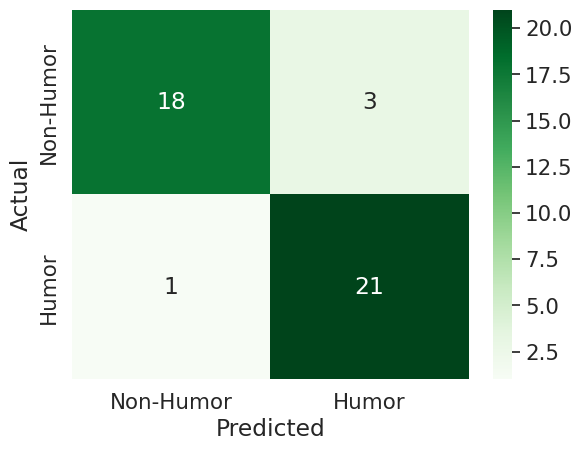

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Evaluate the model on the test set
model.eval()

test_preds = []
test_labels = []

for batch in test_dataloader:
    batch_input_ids = batch[0].to(device)
    batch_attention_masks = batch[1].to(device)
    batch_labels = batch[2].to(device)

    with torch.no_grad():
        outputs = model(
            batch_input_ids,
            token_type_ids=None,
            attention_mask=batch_attention_masks,
            labels=batch_labels
        )

    logits = outputs[1]

    preds = torch.argmax(logits, dim=1).flatten()
    test_preds.extend(preds.cpu().numpy())
    test_labels.extend(batch_labels.cpu().numpy())

# Generate confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Define class labels
class_labels = ['Non-Humor', 'Humor']

# Plot confusion matrix
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
